# Simulating open quantum systems

## Contents

- [Introduction](#intro)
    - [Open quantum systems](#open_systems)
    - [Dynamics in open systems](#open_dynamics)
- [Simulating open quantum systems](#open_simulation)
    - [Basic quantum objects and operations](#qobjects)
    - [Solving the master equation](#master_eq)
- [Example: the quantum teleportation circuit](#example1)
    - [Defining a quantum circuit](#teleportation)
    - [Gate-level circuit simulation](#gates)
- [Example: pulse sequences and noisy components](#example2)
    - [Implementing a circuit on a quantum device](#devices)
    - [Noisy pulse-level circuit simulation](#noise)

## Introduction <a name="intro"></a>

### Open quantum systems <a name="open_systems"></a>

In the lecture notes, we have have seen that the state of a subsystem of a composite quantum
system is naturally described by a density operator, which is a positive semi-definite
operator with unit trace. In particular, given a composite system $\mathcal{H}_A \otimes
\mathcal{H}_B$ in a state $|\psi\rangle_{AB}$, the measurement statistics of any operator
that only acts the subsystem $A$ are entirely captured by the reduced density operator

$$\rho_A = \text{tr}_B(|\psi\rangle_{AB}\langle\psi|_{AB}).$$

Such a reduced density operator is generally refered to as a mixed state. As stated in the
lecture notes, the postulates of quantum mechanics themselves can actually equivalently be
formulated in terms of density operators. In this equivalent reformulation, measurements are
described by POVMs rather than orthogonal projectors, and evolution is described by quantum
channels rather than unitary operators. A physical system that interacts with an environment
that we cannot observe directly is called an **open quantum system**. We typically do not
want to write down the combined state describing the physical system and its environment,
but only limit our attention to the physical system we are interested in. The state of such
an open system is then conveniently described by its density operator.

Although it is equivalent to the more familiar formulation of quantum mechanics in terms of
pure states, the significance of the density operator formalism becomes immediately aparent
when considering the simple fact that *every quantum system encountered in the real world is
an open quantum system*. No matter how carefully one tries to isolate a quantum system from
its environment in an experiment, there will always be some coupling between the system and
the outside world that can never be eliminated. Since any practical quantum system is always
entangled with its environment causing it to decohere, tools for directly simulating the
dynamics of open quantum systems are essential for understanding the behavior of real-world
quantum devices.

In addition, for any system system of significance, an exact analytical description for the
its dynamics simply does not exist. Any description of such a system must therefore resort
to numerical tools to solve the equations governing the dynamics. While this task of
numerically simulating quantum systems is inherently exponentially difficult on classical
hardware, it is still an essential tool in the design and benchmarking of near-term quantum
devices built from semiconductor quantum dots, trapped ions, superconducting circuits, and
many more. As such, a lot of time and effort is being put into developing software that does
just this.

This notebook introduces some aspects of simulating open quantum systems using the
[QuTiP software package](http://qutip.org/). The material covered here has been mostly
adapted from the [QuTiP documentation](https://qutip.readthedocs.io/en/latest/index.html)
and the corresponding [tutorial notebooks](https://qutip.org/qutip-tutorials/).

### Dynamics in opens systems <a name="open_dynamics"></a>

While there is much to be said about the quantum mechanical description of open systems, we
will focus on their **dynamics**.

The dynamics of a closed quantum system is governed by the familiar Schrödinger equation

$$
i\hbar\frac{\partial}{\partial t}|\psi\rangle = H |\psi\rangle,
$$

where $|\psi\rangle$ is the state vector of the system and $H$ is the Hamiltonian. In general,
the Schrödinger equation is a partial differential equation (PDE) where both $|\psi\rangle$
and $H$ are functions of space and time. If we can diagonalize the Hamiltonian in some
appropriate basis at each time, we can in principle solve the Schrödinger equation exactly.
In practice, performing this diagonalization numerically is difficult unless the size of the
Hilbert space is small, and one has to resort to approximation techniques for larger
systems.

Since the synamics of the state vector in a closed system is described by a PDE formulated
in terms of a well-defined Hamiltonian, its evolution is deterministic. In contrast, the
dynamics of open quantum systems is in essence *stochastic* in nature. Intuitively, the
effect of an environment on the system of interest can be understood as inducing stochastic
transitions between energy levels, and introducing uncertainty in the phase difference
between states of the system. These effects are captured in the equations that govern the
dynamics of open quantum systems.

Consider first the combined quantum system consisting of our subsystem of interest and its
environment. This combined system is by definition closed, and the time-evolution of its
density operator $\rho_{\rm tot}(t) = |\psi(t)\rangle_{\rm tot} \langle \psi(t)|_{\rm tot}$
follows directly from the Schrödinger equation and is given by

$$\dot \rho_{\rm tot}(t) = -\frac{i}{\hbar}[H_{\rm tot}, \rho_{\rm tot}(t)],$$

where the total Hamiltonian

$$H_{\rm tot} = H_{\rm sys} + H_{\rm env} + H_{\rm int},$$

includes the interactions within the system of interest $H_{\rm sys}$, the interactions
within the environment $H_{\rm env}$, and a term representing the interaction between the
system and its environment $H_{\rm int}$. To obtain the dynamics we are interested in,
namely the dynamics of the reduced density matrix of our original subsystem $\rho = {\rm
tr}_{\rm env}\left(\rho_{\rm tot}\right)$, we need to trace out all the environment degrees
of freedom in the evolution equation of the full system density matrix. This process results
in what we call the **Lindblad master equation**

$$\dot\rho(t)=-\frac{i}{\hbar}[H(t),\rho(t)]+ \sum_n \gamma_n \left(L_n \rho(t) L_n^\dagger
- \frac{1}{2} \{L_n^\dagger L_n, \rho(t)\} \right)$$

This is the most general trace-preserving and completely positive form for the evolution of
reduced density matrices In this expression, the operators $L_n$ are called **jump
operators**. These precisely represent the stochastic jumps in the system induced due to the
interactions with the environment that we refered to above. The $\gamma_n$ encode the rates
at which the system undergoes these jumps, and are therefore a measure for how 'noisy' the
system is. A derivation of this equation and a discussion of the assumptions that go into
the derivation is beyond the scope of our current dicussion, but can for example be found
[here](https://arxiv.org/abs/1906.04478). We only note that, in order for the Lindblad
master equation to be valid, it is important that the decay rates $\gamma_n$ are smaller
than the minimum energy splitting in the system Hamiltonian.

Simulating the dynamics of a realistic noisy quantum system undergoing decoherence processes
then comes down to numerically integrating the Lindblad master equation.


## Simulating open quantum systems <a name="open_simulation"></a>

Throughout the rest of this notebook, we will make use of the [QuTiP python package](https://qutip.readthedocs.io/en/latest/index.html) and its [quantum information processing module](https://qutip-qip.readthedocs.io/en/stable/index.html). It provides all the functionalities we require here.

<div class="alert alert-block alert-info"> <b>From the qutip documentation:</b> <i>The Quantum Toolbox in Python, or QuTiP, is an open-source framework written in the Python programming language, designed for simulating the dynamics of open quantum systems.</i> </div>

### Basic quantum objects and operations <a name="qobjects"></a>

Before moving on to any actual simulations, let's first go through a few of the QuTiP basics we will need. You can find a more in-depth tutorial [here](https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v5/lectures/Lecture-0-Introduction-to-QuTiP.ipynb).

In [80]:
import qutip as qt

##### [Quantum states](https://qutip.readthedocs.io/en/latest/apidoc/functions.html#module-qutip.core.states)

##### State vectors

Let's start our discussion by considering the state of a single qubit, which lives in a two-dimensional Hilbert space spanned by the basis $\{|0\rangle, |1\rangle\}$. In QuTiP, a basis state can be initialized through the [`basis` function](https://qutip.readthedocs.io/en/qutip-5.0.x/apidoc/functions.html#qutip.core.states.basis), by supplying the total Hilbert space dimension as well as the integer label of the basis state. For example, the state $|1\rangle$ can be created as follows.

In [81]:
b = qt.basis(2, 1)  # equivalent to fock(N, n)
b

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]]

This basis state is an instance of a the `Qobj` type defined in QuTip. Using our basis state we can inspect some [basic properties of `Qobj` instances](https://qutip.readthedocs.io/en/latest/guide/guide-basics.html#the-quantum-object-class).

In [82]:
# the dimension, which encodes composite Hilbert state space structure
b.dims

[[2], [1]]

In [83]:
# the shape of the internal matrix data representation
b.shape

(2, 1)

In [84]:
# the matrix data itself, in some internal format
b.data

Dense(shape=(2, 1), fortran=True)

In [85]:
# get the dense matrix representation
b.full()

array([[0.+0.j],
       [1.+0.j]])

In [86]:
# some additional properties
b.isherm, b.type

(False, 'ket')

In particular, we can take the adjoint of a regular 'ket' quantum state to obtain its dual 'bra' operator using the [`dag` method](https://qutip.readthedocs.io/en/stable/apidoc/classes.html#qutip.core.qobj.Qobj.diag).

In [87]:
# dagger turns a ket into a bra
b.dag()

Quantum object: dims=[[1], [2]], shape=(1, 2), type='bra', dtype=Dense
Qobj data =
[[0. 1.]]

##### Density operators

Instances of `Qobj` can not only represent state vectors, but also density operators as well as more general operators. For example, the density operator corresponding to our basis state `b` can be obtained as:

In [88]:
# pure state density matrix
rho = b * b.dag()
rho # is a Hermitian operator

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [89]:
# with unit trace
rho.tr()

1.0

#### [Operators](https://qutip.readthedocs.io/en/latest/apidoc/functions.html#module-qutip.core.operators)

QuTiP directly exports some basic quantum operators, such as the familiar Pauli operators:

In [90]:
# Pauli X
qt.sigmax()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [91]:
# Pauli Y
qt.sigmay()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

In [92]:
# Pauli Z
qt.sigmay()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

A more exhaustive set of elementary gates is provided by the [`qutip_qip` module](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.operations.html#) for quantum information processing built on top of QuTiP.

#### [Tensor products](https://qutip.readthedocs.io/en/latest/apidoc/functions.html#module-qutip.core.tensor)

To work with composite systems, we can take tensor products of quantum objects using the [`tensor` function](https://qutip.readthedocs.io/en/latest/apidoc/functions.html#qutip.core.tensor.tensor). For example, the three-qubit state $|1\rangle \otimes |1\rangle \otimes |1\rangle$ can be created as:

In [93]:
bbb = qt.tensor(b, b, b)
bbb # note the dims field reflects the composite structure

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

Similarly, a composite operator $X \otimes I \otimes Y$ can be created as:

In [94]:
XIY = qt.tensor(qt.sigmax(), qt.qeye(2), qt.sigmay())
XIY # note the dims field reflects the composite structure

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

Operators can be applied to states by using the `*` operator.

In [95]:
XIY * bbb

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.+0.j]
 [0.+0.j]
 [0.-1.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]

### Solving the master equation with Qutip <a name="master_eq"></a>

In [96]:
import numpy as np
import matplotlib.pyplot as plt

QuTiP is designed to make it easy to simulate the dynamics of open quantum systems. It exports a solver for the Lindblad master equation through the [`mesolve` function](https://qutip.readthedocs.io/en/latest/apidoc/functions.html#qutip.solver.mesolve.mesolve) function. This function integrates the Lindblad master equation for a given Hamiltonian, a set of jump operators and decay rates, and returns the time-evolution of the density matrix for the system. In particular, its calling syntax is:

```python
mesolve(H, rho0, tlist, c_ops=None, e_ops=None)
```

To use it, we need a Hamiltian `H`, an initial state `rho0`, a list `tlist` of times for which we want the integration result, a list `c_ops` of so-called **collapse operators**, and a list `e_ops` of operators to measure at each time in `tlist`. The collapse operators $C_n$ are nothing more than the product of the jump operators and the square root of the decay rates, $C_n := \sqrt{\gamma_n} L_n$.

As a very simple example of simulating open quantum dynamics with `mesolve`, we will consider time evolution of a single spin-1/2 particle with a tunneling rate $R$ that is initially in the up-state $|0\rangle$, which dissipates energy to its environment at a rate $\gamma$.

The Hamiltonian of this system is given by
$$H = 2\pi R \sigma_x,$$
where we will set the tunneling rate to to be $R=0.1$ in our example. The energy dissipation to the environment can be modeled as a relaxation process corresponding to a jump operator $L = \sigma_x$, and we will set the corresponding relaxation rate at $\gamma = 0.05$.

We will simulate the time evolution of this system up to a total time total time of $t=10$, where we will track the time evolution of the expectation value of the operators $\sigma_z$ and $\sigma_y$ throughout 100 steps along the time evolution.

The `mesolve` documentation provides us with all the information we need to actually do this.

In [97]:
times = np.linspace(0.0, 10.0, 100)

H = 2*np.pi * 0.1 * qt.sigmax()
rho0 = qt.basis(2, 0) * qt.basis(2, 0).dag()
c_ops = [np.sqrt(0.05) * qt.sigmax()]
e_ops = [qt.sigmaz(), qt.sigmay()]

result = qt.mesolve(H, rho0, times, c_ops=c_ops, e_ops=e_ops)

From the [QuTiP solver result](https://qutip.readthedocs.io/en/latest/apidoc/classes.html#qutip.solver.result.Result), we can plot the evolution of the expecation values of the operators $\sigma_z$ and $\sigma_y$ as a function of time.

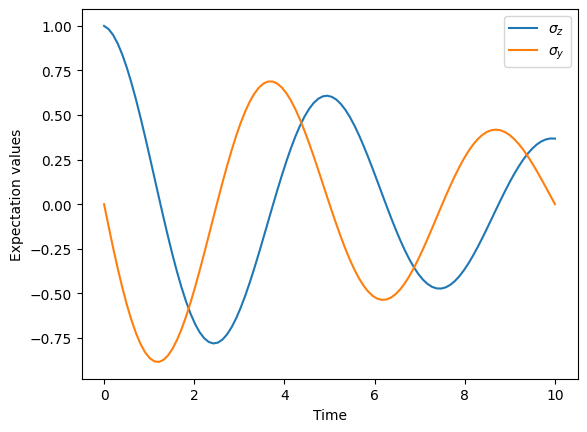

In [98]:
fig, ax = plt.subplots()
ax.plot(times, result.expect[0])
ax.plot(times, result.expect[1])
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend((r"$\sigma_z$", r"$\sigma_y$"))
plt.show()

Note the oscillating behavior, with a clear decay in the amplitude of the oscillations. This is a clear signature of energy dissipation to the environment.

Indeed, if we compare our result to what we would get when [integrating the Schrödinger equation](https://qutip.readthedocs.io/en/stable/apidoc/functions.html#qutip.solver.sesolve.sesolve) for the same system, ignoring the dissipation, we would see that the oscillations would continue indefinitely.

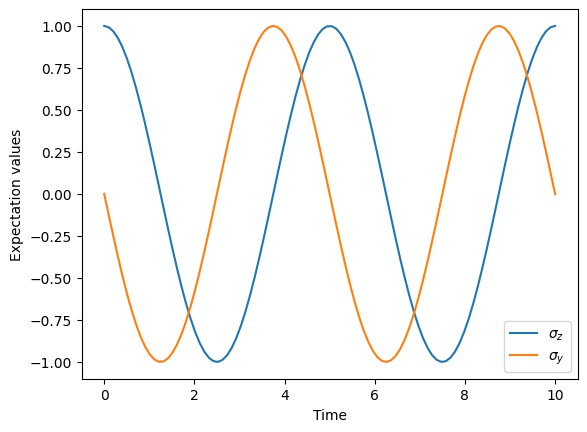

In [99]:
noiseless_result = qt.sesolve(H, qt.basis(2, 0), times, e_ops=e_ops)
fig, ax = plt.subplots()
ax.plot(noiseless_result.times, noiseless_result.expect[0])
ax.plot(noiseless_result.times, noiseless_result.expect[1])
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend((r"$\sigma_z$", r"$\sigma_y$"))
plt.show()

In the following, we will move away from directly simulating a physical system by defining its Hamiltonian manually, and instead focus on an example of a simple quantum circuit. While we will not use `mesolve` directly in this example, the QuTiP framework that simulates the execution of such a quantum circuit on a noisy device usees `mesolve` under the hood.

## Example: the quantum teleportation circuit <a name="example1"></a>

After this general introduction to dynamics in open quantum systems, we will now move on to a concrete example that is more relevant to the course, namely the quantum teleportation circuit. This simple 3-qubit circuit contains only basic quantum gates and measurements, making it an ideal test case.

We will start by implementing the circuit

<center><img src="./fig/teleportation.svg" alt="teleportation"/></center>


from the lecture notes in QuTiP. We will then use this circuit to perform a very basic *gate-level simulation*, to demonstrate the use of numerical tools for analytically analyzing circuits. In the next section, we will look at what a more realistic simulation of the same circuit when it is actually executed on a quantum device would look like.

### Defining a quantum circuit <a name="teleportation"></a>

In [100]:
from qutip_qip.circuit import QubitCircuit
from math import sqrt

A quantum circuit can be represented in QuTiP as an instance of the [`QubitCircuit` class](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.circuit.html#qutip_qip.circuit.QubitCircuit). After initializing an empty `QubitCicuit` with the appropriate nummber of qubits, we can add the gates and measurements in the circuit one by one using the [`add_gate`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.circuit.html#qutip_qip.circuit.QubitCircuit.add_gate) and [`add_measurement`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.circuit.html#qutip_qip.circuit.QubitCircuit.add_measurement) methods.

A list of available buitin gates can be found [here](https://qutip-qip.readthedocs.io/en/stable/qip-basics.html#gates).

For our example, we will require the "SNOT" gate representing a single-qubit Hadamard gate, the "CNOT" gate representing a controlled-$X$ gate, and the "CSIGN" gate representing a controlled-$Z$ gate. We will also need to add measurements to the circuit.

The circuit consists of three qubits which we will label $0$, $1$ and $2$. Qubits $0$ and $1$ belong to Alice and are initialized in the states $|\psi\rangle$ and $|0\rangle$, respectively, where $|\psi\rangle$ is the state Alice intends to teleport to Bob. Qubit $2$ belongs to Bob is initialized in the state $|0\rangle$.

We start by initializing an empty circuit, annotating the initial state of the three qubits:

In [101]:
teleportation = QubitCircuit(3, input_states=[r"\psi_A", r"0_A", r"0_B"])

The first step of the circuits consists of encoding Bell state between Alice and Bob's ancilla $|0\rangle$ states (where one qubit of the pair is then given to each of them):

In [102]:
teleportation.add_gate("SNOT", targets=[1])
teleportation.add_gate("CNOT", targets=[2], controls=[1])

In a second step, Alice entangles her part of the Bell state with the state to be teleported:

In [103]:
teleportation.add_gate("CNOT", targets=[1], controls=[0])
teleportation.add_gate("SNOT", targets=[0])

Finally, Alice measures her two qubits in the computational basis, and communicates the result to Bob. Conditioned on the measurement result, Bob then applies and $X$ and/or $Z$ to his qubit to obtain the state $|\psi\rangle$. This procedure can equivalently be formulated in terms of controlloed operations between Alice's two qubits and Bob's qubit, with a delayed measurement at the end:

In [104]:
teleportation.add_gate("CNOT", targets=[2], controls=[1])
teleportation.add_gate("CSIGN", targets=[2], controls=[0])

teleportation.add_measurement("M0", targets=[0])
teleportation.add_measurement("M1", targets=[1])

We can plot our `teleportation` circuit to see if it is correct:

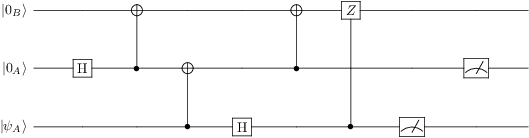

In [105]:
teleportation

This should look exactly like the circuit given above, just flipped upside down.

### Gate-level circuit simulation <a name="gates"></a>

The `QubitCircuit` class provides a [`run`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.circuit.html#qutip_qip.circuit.QubitCircuit.run) method that allows us to simulate the circuit at the gate level. Given some initial state, this method returns the final state after annalytically applying all the gates and measurements in the circuit.

We'll try this out for an initial state $|\psi\rangle = |+\rangle$:

In [106]:
psi = 1 / sqrt(2) * qt.basis(2, 0) + 1 / sqrt(2) * qt.basis(2, 1)
psi

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.70710678]]

Tensoring this state with two ancillas in the $|0\rangle$ state and passing it to `run` allows us to obtain the final state after gates and measurements.

In [107]:
state_initial = qt.tensor(psi, qt.basis(2, 0), qt.basis(2, 0))  
state_final = teleportation.run(state_initial)
state_final # the final state will be different between runs, depending on the measurement outcomes

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]

We can check if the teleportation worked by checking if Bob actually ends up with a $|+\rangle> state. We can do this by constructing a projector $I \otimes I \otimes |+\rangle\langle+|$ which projects Bob's qubit onto the $|+\rangle$ state, and computing its expectation value.

In [119]:
P = qt.tensor(qt.qeye(2), qt.qeye(2), psi * psi.dag())
print(f"Overlap between initial and teleported state: {state_final.dag() * P * state_final}")

Overlap between initial and teleported state: (0.9999999999999997+0j)


This will always work, regardless of the actual measurement outcome or the initial state. You can try some other initial states and investigate the [`run` statistics](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.circuit.html?highlight=run_statistics#qutip_qip.circuit.CircuitSimulator.run_statistics) to verify this.

## Example: pulse sequences and noisy components <a name="example2"></a>

An analytic circuit simulation like the one we just did can come in handy sometimes.
However, it is not very representative of the result of actually running this circuit on a
physical device, as we will discuss next.

### Implementing a circuit on a quantum device <a name="devices"></a>

We have seen many circuits throughout the lectures, but we have never really considered how
a quantum circuit actually executed on a physical devices.

The quantum circuits we have considered act on qubits, which are abstract objects
representing the simplest two-level quantum system. Various hardware platforms have been
devised which can serve as a physical realization of these abstract entities, including
superconducting systems, trapped ions, neutral atoms and semiconductor quantum dots. A real
quantum computer consists of a collection of these physical qubits, which can be
individually controlled as well as coupled along the connections dictated by the device
geometry. Running a quantum circuit consisting of some set of gates on such a device then
similarly requires a physical implementation of these gates. To this end, a given circuit is
typically compiled to a sequence of control pulses that drive the physical components and
their couplings. These pulses implement time-dependent interactions, the nature of which
depends on the specific hardware platform, and are chosen in such a way that the
corresponding dynamics precisely implement the appropriate gate sequence on the physical
level.

Since any real component is inherently subject to noise and dissipation, we conclude that
studying the execution of circuits on real quantum devices corresponds to studying the
time-dependent dynamics of the corresponding noisy physical system as it is driven by
control pulses. As an example of this, we will simulate the execution of the above
teleportation circuit on a realistic device
[using QuTiP](https://qutip-qip.readthedocs.io/en/stable/qip-processor.html#pulse-level-circuit-simulation).

In our example, we will choose a physical implementation of a qubit as a single spin-1/2 particles, which could for example correspond to a single electron in a quantom dot. In particular, we will consider a linear chain of three of these spin qubits as our complete physical system. In QuTiP, such a system is represented as a [`LinearSpinChain`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.device.html#qutip_qip.device.LinearSpinChain).

The dynamics of this spin chain can be controlled through a [time-dependent Hamiltonian](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.device.html#qutip_qip.device.SpinChainModel) of the form
$$
H=
\sum_{j=0}^{N-1}
\Omega^x_{j}(t) \sigma^x_{j} +
\Omega^z_{j}(t) \sigma^z_{j} + \sum_{j=0}^{N-2}
g_{j}(t)
(\sigma^x_{j}\sigma^x_{j+1}+
\sigma^y_{j}\sigma^y_{j+1}).
$$
To run a circuit on this device, it is transformed into a time sequence of control pulses that encode the values of the prefactors $\Omega^x_{j}(t)$ and $\Omega^z_{j}(t)$ of the single-qubit drives $\sigma_j^x$ and $\sigma_j^z$, and the coupling strengths $g_{j}(t)$ of the nearest-neighbor interation $\sigma^x_{j}\sigma^x_{j+1}+\sigma^y_{j}\sigma^y_{j+1}$ at each time step.

We can convert our teleportation circuit to a pulse sequence on a `LinearSpinChain` using the [`load_circuit` method](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.device.html#qutip_qip.device.LinearSpinChain.load_circuit).

In [109]:
from qutip_qip.device import LinearSpinChain

In [110]:
# remove measurements, these are not really relevant right now
teleportation.remove_gate_or_measurement(name="M0")
teleportation.remove_gate_or_measurement(name="M1")

# initialize device and load circuit for compilation
processor = LinearSpinChain(3)
processor.load_circuit(teleportation);

Once we have our device and loaded in the circuit, we can simply plot the corresponding pulse sequence:

/tmp/ipykernel_128005/3559968191.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


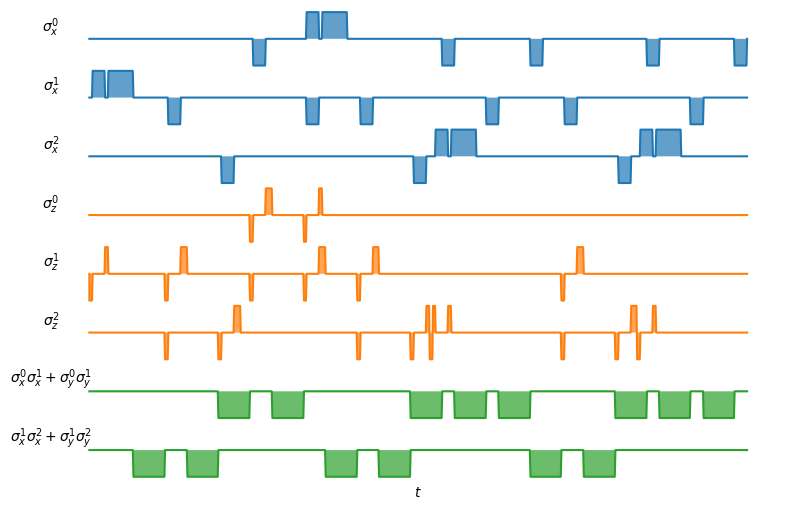

In [111]:
fig, ax = processor.plot_pulses(figsize=(8, 5))
ax[-1].set_xlabel("$t$")
fig.show()

Given our device and a circuit, we can simulate its execution on the device using the [`run_state` method](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.device.html#qutip_qip.device.Processor.run_state). This can either be done analytically, or by integrating the time-dependent pulse dynamics using `mesolve`

In [112]:
# regular gate-level circuit run
state_final1 = teleportation.run(state_initial)

# analytic device run
propagators = processor.run_state(state_initial, analytical=True)
state_final2 = propagators[0]
for U in propagators[1:]:
    state_final2 = U * state_final2
print(f"Fidelity between gate-level and analytical run: {qt.fidelity(state_final1, state_final2)}") # perfect

# pulse-level device run
state_final3 = processor.run_state(state_initial).states[-1]
print(f"Fidelity between gate-level and pulse-level run: {qt.fidelity(state_final1, state_final3)}") # very good

Fidelity between gate-level and analytical run: 0.9999999999999982
Fidelity between gate-level and pulse-level run: 0.9999999241124827


/home/leburgel/Dropbox/phd/teaching/QComp/2023-2024/Tutorials/numerics_session/venv/lib/python3.9/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


At this point, we have not yet considered noise in the device. Indeed, we see that even when integrating the pulse-level dynamics the result lies very close to the analytical expectation.

In [113]:
processor.get_noise() # no actual noise by default

[]

### Noisy pulse-level circuit simulation <a name="noise"></a>

In [114]:
from qutip_qip.noise import RelaxationNoise, RandomNoise

To actually make our simulations realistic, we should [take into account the noise](https://qutip-qip.readthedocs.io/en/stable/qip-processor.html#noise-simulation) that will actually occur in the device. This noise will then be reflected as jump operators in the master equation that cause the system to decohere, and decrease the resulting fidelity of the teleportation circuit. To see this, we will repeat the above simulation where we will now take into account two types of noise.

The first type is physical *relaxation noise* caused by the inevitable interactions of our spin qubits with their environment. This type of noise is usually modeled in terms of two 'lifetimes' of a qubit, namely the coherence time $t_1$ and the dephasing time $t_2$.

Physically, these two times directly dictate the decay rates of two Lindblad jump operators:
- the decoherence operator $L = \sigma^-$ with rate $1/\sqrt{t_1}$, where $a$ is the bosonic destruction operator for an $n$-level system
- dephasing operator $L = \sigma^+ \sigma^-$ with rate $\sqrt{2/t_2^*}$, where $a^+ a^- = \hat n$ is the bosonic number operator for an $n$-level system and $t_2^*$ is the pure dephasing time given by $1/t_2^* = 1/t_2 - 1/(2t_1)$

This type of noise can be modeled through the [`RelaxationNoise`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.noise.html#qutip_qip.noise.RelaxationNoise) class which takes these two lifetimes as input.

In [115]:
relaxation_noise = RelaxationNoise(t1=52., t2=77.) # lifetimes correspond to an actual IBM device spec

The second type of noise is control pulse amplitude noise, and corresponds to random fluctuations in the amplitude of the control pulse signals we have plotten before. This type of noise can be modeled through the [`RandomNoise`](https://qutip-qip.readthedocs.io/en/stable/apidoc/qutip_qip.noise.html#qutip_qip.noise.RandomNoise) class as:

In [116]:
control_noise = RandomNoise(
    dt=0.01, rand_gen=np.random.normal, loc=0.00, scale=0.02) # realistic control pulse noise

We can then add this noise to our device, repeat the pulse-level simulation and compare the resulting fidelity to what we obtained before.

In [117]:
processor.add_noise(relaxation_noise)
processor.add_noise(control_noise)
processor.get_noise()

In [118]:
state_final4 = processor.run_state(state_initial).states[-1]
print(f"Fidelity between gate-level and noisy pulse-level run: {qt.fidelity(state_final1, state_final4)}")

Fidelity between gate-level and noisy pulse-level run: 0.7073021825294867


This fidelity is a lot lower than what we obtained before. Indeed, physical noise in quantum poses a formidable challenge to any sizeable quantum computation!